# Mean-preserving spread in the McCall (1970) model



In this problem, we study the solution to the recursive problem

\begin{equation}
V\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .
\end{equation}

The optimal solution is characterized by a reservation wage $\bar{w}$ that satisfies

\begin{equation}
\bar{w}-c=\frac{\beta }{1-\beta }\int_{\bar{w}}^{B}\left( w^{\prime }-\bar{w}%
\right) dF\left( w^{\prime }\right) \text{.} 
\end{equation}

Defining the function

$$g(w) = w - c - \frac{\beta }{1-\beta }\int_{{w}}^{B}\left( w^{\prime }-{w}%
\right) dF\left( w^{\prime }\right) \text{,}  $$

the reservation wage $\bar{w}$ is the solution to $g(w) = 0$.

We are studying the sensitivity of the reservation wage to changes in the mean-preserving spread, modeled via increases in variance of Beta-distributed offer distribution. In particular, when the wage offer

$$ W\sim Beta\left(\alpha_w, \beta_w\right) $$

then

$$ E[W] = \frac{\alpha_w}{\alpha_w + \beta_w} \qquad Var[W] = \frac{\alpha_w \beta_w}{\left(\alpha_w+\beta_w\right)^2\left(\alpha_w + \beta_w +1\right)}  $$

so decreasing both $\alpha_w$ and $\beta_w$ proportionally preserves the mean, while increasing the variance of the distribution.

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np
from scipy import stats

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Specify the quadrature method to numerically evaluate the integral in function $g(w)$.

In [3]:
# simple_quadrature constructs an equidistant grid quadrature rule on interval r, either from density f or cdf F
# the functions f or F need to be provided as arguments, param is the parameter vector (can be empty)
def simple_quadrature(r=[0,1],I=10,f="",F="",param=""):
    if F:
        # construct weights from F
        nodes = np.linspace(r[0],r[1],I)
        weights = np.linspace(r[0],r[1],I)
        weights[1:-1] = F((nodes[2:]+nodes[1:-1])/2,param) - F((nodes[1:-1]+nodes[:-2])/2,param)
        weights[0] = F((nodes[1]+nodes[0])/2,param) - F(nodes[0],param)
        weights[-1] = F(nodes[-1],param) - F((nodes[-1]+nodes[-2])/2,param)
    elif f:
        nodes = np.linspace(r[0],r[1],I)
        weights = f(nodes,param)
        # nodes at boundaries receive half weight
        weights[0] /= 2
        weights[-1] /= 2
        # renormalize weights to sum up to one
        weights = weights/sum(weights)
    else:
        print('Neither pdf nor cdf were defined.')
            
    return nodes, weights

Define the Newton&ndash;Raphson method for finding the reservation wage by solving $g(w)=0$.

In [4]:
def reservation_wage_newton_raphson(model):
    
    B = model["B"]
    I = model["I"]
    F_cdf = model["F_cdf"]
    F_param = model["F_param"]
    bet = model["beta"]
    c = model["c"]
    
    wold,wnew = 0, B/2
    eps = 10**(-10)
    iters = 0
    while abs(wold-wnew) > eps:
        wold = wnew
        w_nodes,weights = simple_quadrature(r=[wold,B],I = I,F=F_cdf,param=F_param)
        g = wold - c - bet/(1-bet)*((w_nodes-wold)@weights)
        dg = (1-bet*F_cdf(wold,F_param))/(1-bet)
        
        wnew = wold - g/dg
        iters += 1
        
    return wnew,iters

Solve for reservation wages as a function of parameters of the Beta distribution of wages offers.

In [5]:
# F is beta cdf on [0,1], with parameters [alpha,beta]
def F_beta(w,param):
    alph = param[0]
    bet = param[1]
    return stats.beta.cdf(w,alph,bet)

# define baseline model parameters
model = {"beta":0.96, "B": 1, "c": 0.2, "F_cdf": F_beta, "I" : 1000, "F_param": [10,10]}

# choose a grid of decreasing values alpha_w, beta_w from 100 to 0.01 (log-spaced grid spaces the values better for this purpose)
N = 50
alpha_vec = np.logspace(2,-2,N)
beta_vec = np.logspace(2,-2,N)
wbar_vec = np.zeros(N)
Var_vec = alpha_vec*beta_vec / ((alpha_vec+beta_vec)**2*(alpha_vec+beta_vec+1))

for i,alph in enumerate(alpha_vec):
    bet = beta_vec[i]
    model["F_param"] = [alph,bet]
    wbar,it = reservation_wage_newton_raphson(model)
    wbar_vec[i] = wbar

Plot the resulting relationship between the variance of the offer distribution and the reservation wage.

Plotting the reservation wage as a function of the variance of the offer distribution.


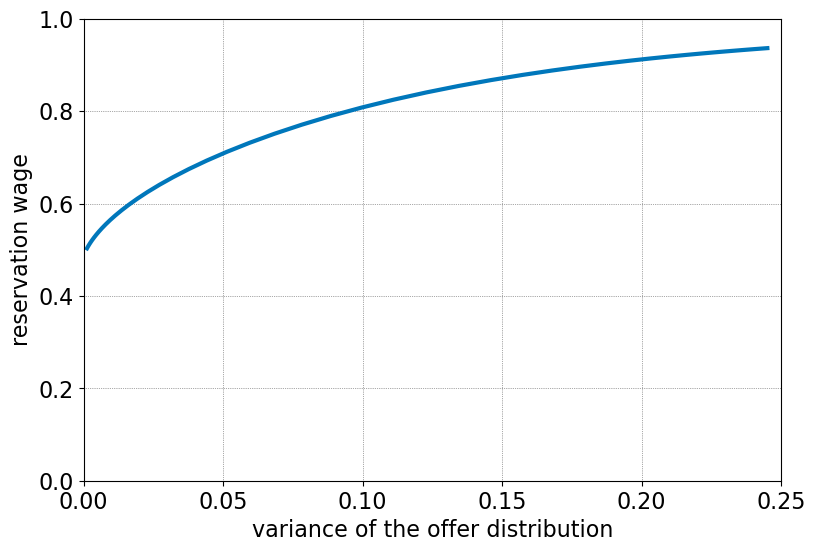

In [7]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,0.25], 'ylim': [0,1],
         'xlabel': 'variance of the offer distribution', 'ylabel': 'reservation wage',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

print('Plotting the reservation wage as a function of the variance of the offer distribution.')
fig,ax = ec.GenerateTSPlot(param)

ax.plot(Var_vec,wbar_vec,linewidth=3,color=ec.tolColor['tolVibrantBlue'],linestyle='solid');

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + 'search_mccall_mean_preserving_spread.pdf',bbox_inches='tight')